# 0-Libraries

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import itertools
import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report,ConfusionMatrixDisplay, balanced_accuracy_score
#from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import Normalizer, StandardScaler, MinMaxScaler, MaxAbsScaler, RobustScaler, QuantileTransformer, PowerTransformer
import tensorflow as tf
from tensorflow import keras
from keras import regularizers
from keras.optimizers import Adam
#from keras.backend import expand_dims
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.models import Sequential
from keras.constraints import MaxNorm
from keras.layers import Activation, Dense, Conv1D, Flatten, MaxPooling1D, Dropout, BatchNormalization, SpatialDropout1D

In [9]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'),
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

# 1- Load Data

In [10]:
s_aureus = pd.read_csv('/content/e_coli_driams_b_2000_20000Da_v2 (1).csv')
s_aureus.head()

,2000,2003,2006,2009,2012,2015,2018,2021,2024,2027,...,19988,19991,19994,19997,code,species,Ciprofloxacin,Ceftriaxone,Cefepime,Piperacillin-Tazobactam
0,1067.142857,1251.714286,1310.571429,1021.142857,1315.625000,974.000000,936.857143,853.571429,936.142857,1044.285714,...,21.5,6.500000,4.666667,17.585859,dcd5aa31-b254-4961-b69f-ccc8c0572b27,Escherichia coli,0.0,0.0,0.0,0.0
1,1872.857143,1677.285714,2035.714286,2086.250000,1930.571429,2017.142857,1856.857143,1655.857143,1547.142857,1713.000000,...,21.0,15.000000,26.500000,21.736842,dfcb7221-e4f8-4a39-b661-7e439f19e93d,Escherichia coli,0.0,0.0,0.0,0.0
2,3258.142857,3209.428571,3068.571429,3162.428571,3275.000000,3324.571429,2999.000000,2970.500000,3213.000000,3205.571429,...,17.0,17.000000,30.000000,19.125000,d5bb4389-5053-4107-9c05-bfed9e9159c9,Escherichia coli,0.0,0.0,0.0,0.0
3,18912.571429,19530.571429,19464.875000,19098.714286,18994.714286,18936.285714,19208.571429,19417.571429,19486.857143,19048.625000,...,299.0,339.500000,359.000000,311.746032,4e14943f-ae22-42ed-aef5-65430470dcfa,Escherichia coli,0.0,0.0,0.0,0.0
4,1685.000000,1537.428571,1283.714286,1472.285714,1370.142857,1402.142857,1397.500000,1422.142857,1725.285714,3386.714286,...,32.5,48.333333,66.500000,39.230769,617f14d0-86b1-4c28-8995-b02006a85e81,Escherichia coli,1.0,1.0,1.0,1.0


# Preprocessing Data

In [12]:
s_aureus = s_aureus.drop(columns=['code','species', 'Ceftriaxone', 'Cefepime', 'Piperacillin-Tazobactam'])
s_aureus.dropna(axis=0, how="any", inplace=True)

In [13]:
s_aureus.head()

,2000,2003,2006,2009,2012,2015,2018,2021,2024,2027,...,19973,19976,19979,19982,19985,19988,19991,19994,19997,Ciprofloxacin
0,1067.142857,1251.714286,1310.571429,1021.142857,1315.625000,974.000000,936.857143,853.571429,936.142857,1044.285714,...,19.666667,20.000000,23.0,42.666667,15.000000,21.5,6.500000,4.666667,17.585859,0.0
1,1872.857143,1677.285714,2035.714286,2086.250000,1930.571429,2017.142857,1856.857143,1655.857143,1547.142857,1713.000000,...,32.000000,29.666667,30.0,18.000000,17.000000,21.0,15.000000,26.500000,21.736842,0.0
2,3258.142857,3209.428571,3068.571429,3162.428571,3275.000000,3324.571429,2999.000000,2970.500000,3213.000000,3205.571429,...,19.666667,20.000000,23.5,14.500000,13.666667,17.0,17.000000,30.000000,19.125000,0.0
3,18912.571429,19530.571429,19464.875000,19098.714286,18994.714286,18936.285714,19208.571429,19417.571429,19486.857143,19048.625000,...,299.000000,269.333333,282.0,300.500000,311.000000,299.0,339.500000,359.000000,311.746032,0.0
4,1685.000000,1537.428571,1283.714286,1472.285714,1370.142857,1402.142857,1397.500000,1422.142857,1725.285714,3386.714286,...,25.000000,34.000000,33.0,37.333333,21.000000,32.5,48.333333,66.500000,39.230769,1.0


In [14]:
bacteria = s_aureus.columns[-1]

In [15]:
print('clase minoritaria',s_aureus[s_aureus[bacteria] == 1].shape[0])
print('clase mayoritaria',s_aureus[s_aureus[bacteria] == 0].shape[0])

clase minoritaria 59
clase mayoritaria 154


In [16]:
X = s_aureus.iloc[:, 0:6000].values  # variables independientes (espectros de masa)
y = s_aureus.iloc[:, 6000].values    # variable dependientes (resistencia a ciprofloxacin)
X = np.asarray(X).astype(np.float32)
y = np.asarray(y).astype(np.float32)

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0, stratify=y)

In [18]:
X_train.shape

(170, 6000)

## Enfoque en clase minoritaria

In [19]:
minority_class = s_aureus[s_aureus[bacteria] == 1].drop(columns=[bacteria])


In [20]:
minority_class.head()

,2000,2003,2006,2009,2012,2015,2018,2021,2024,2027,...,19970,19973,19976,19979,19982,19985,19988,19991,19994,19997
4,1685.000000,1537.428571,1283.714286,1472.285714,1370.142857,1402.142857,1397.500000,1422.142857,1725.285714,3386.714286,...,38.333333,25.000000,34.000000,33.000000,37.333333,21.0,32.500000,48.333333,66.500000,39.230769
6,2609.857143,2827.714286,2829.285714,2664.375000,2552.714286,2823.285714,2694.571429,2847.285714,2661.571429,2544.285714,...,114.000000,112.000000,132.333333,97.500000,113.000000,151.0,108.666667,113.000000,88.000000,97.010309
21,2461.714286,2371.875000,3136.000000,2858.142857,2427.571429,2449.714286,2436.285714,2194.125000,2246.428571,2538.714286,...,156.500000,163.333333,177.000000,182.500000,154.500000,172.0,182.500000,152.500000,125.500000,156.954955
23,2263.142857,2272.428571,2201.428571,2340.571429,1961.000000,2168.285714,2264.142857,2209.000000,2118.000000,2267.571429,...,12.500000,7.333333,2.000000,11.500000,19.333333,9.0,6.000000,15.000000,5.333333,10.547170
24,4392.142857,4385.857143,4368.000000,4249.714286,4252.142857,4330.285714,4398.250000,4322.285714,4141.428571,4183.285714,...,19.000000,21.000000,6.000000,15.333333,6.000000,6.0,24.333333,5.000000,18.000000,13.500000


In [22]:
pip install sdv

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.3/154.3 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.2/139.2 kB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 77.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.4/52.4 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.1/179.1 kB 18.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 81.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.2/83.2 kB 8.7 MB/s eta 0:00:00


In [23]:
from sdv.metadata import SingleTableMetadata

# Crear un objeto Metadata para el dataset
metadata = SingleTableMetadata()

# Detectar automáticamente los tipos de datos del DataFrame
metadata.detect_from_dataframe(minority_class)

# Visualizar el metadata generado
print(metadata.to_dict())

{'columns': {'2000': {'sdtype': 'numerical'}, '2003': {'sdtype': 'numerical'}, '2006': {'sdtype': 'numerical'}, '2009': {'sdtype': 'numerical'}, '2012': {'sdtype': 'numerical'}, '2015': {'sdtype': 'numerical'}, '2018': {'sdtype': 'numerical'}, '2021': {'sdtype': 'numerical'}, '2024': {'sdtype': 'numerical'}, '2027': {'sdtype': 'numerical'}, '2030': {'sdtype': 'numerical'}, '2033': {'sdtype': 'numerical'}, '2036': {'sdtype': 'numerical'}, '2039': {'sdtype': 'numerical'}, '2042': {'sdtype': 'numerical'}, '2045': {'sdtype': 'numerical'}, '2048': {'sdtype': 'numerical'}, '2051': {'sdtype': 'numerical'}, '2054': {'sdtype': 'numerical'}, '2057': {'sdtype': 'numerical'}, '2060': {'sdtype': 'numerical'}, '2063': {'sdtype': 'numerical'}, '2066': {'sdtype': 'numerical'}, '2069': {'sdtype': 'numerical'}, '2072': {'sdtype': 'numerical'}, '2075': {'sdtype': 'numerical'}, '2078': {'sdtype': 'numerical'}, '2081': {'sdtype': 'numerical'}, '2084': {'sdtype': 'numerical'}, '2087': {'sdtype': 'numerical'

In [24]:
from sdv.single_table import GaussianCopulaSynthesizer

synthesizer = GaussianCopulaSynthesizer(metadata)

/usr/local/lib/python3.10/dist-packages/sdv/single_table/base.py:119: FutureWarning: The 'SingleTableMetadata' is deprecated. Please use the new 'Metadata' class for synthesizers.
  warnings.warn(DEPRECATION_MSG, FutureWarning)
/usr/local/lib/python3.10/dist-packages/sdv/single_table/base.py:104: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(


In [25]:
synthesizer.fit(
    data=minority_class
)




In [26]:

# Guardar el modelo
synthesizer.save('./modeloCopula.h5')


In [27]:
import os

In [28]:
os.system('ls')

0

In [29]:
from tensorflow.keras.models import load_model

# Cargar el modelo
synthesizer = load_model('/content/modeloCopula.h5')

OSError: Unable to synchronously open file (file signature not found)

In [ ]:
s_aureus[s_aureus[bacteria] == 0].shape[0]-s_aureus[s_aureus[bacteria] == 1].shape[0]

95

In [30]:
synthetic_data = synthesizer.sample(
    pd.Series(y_train).value_counts()[0]-pd.Series(y_train).value_counts()[1]
)

In [31]:
synthetic_data.shape

(76, 6000)

In [32]:

# Cambiar el tipo de datos a float32
synthetic_samples_numpy_copula = synthetic_data.astype(np.float32)

# Mostrar las muestras generadas
synthetic_samples_numpy_copula.shape

(76, 6000)

In [33]:
X_train_resampled = np.concatenate([X_train,synthetic_samples_numpy_copula])

In [34]:
s_aureus[s_aureus[bacteria] == 0].shape

(154, 6001)

In [35]:
X_train.shape

(170, 6000)

In [36]:
int((pd.Series(y_train).value_counts()[0]-pd.Series(y_train).value_counts()[1]))

76

In [37]:
ones_array = np.ones(int((pd.Series(y_train).value_counts()[0]-pd.Series(y_train).value_counts()[1])))
y_train_resampled = np.concatenate([y_train,ones_array])
y_train_resampled.shape

(246,)

In [38]:
print(pd.Series(y_train_resampled).value_counts())


0.0    123
1.0    123
Name: count, dtype: int64


In [39]:
scaler=Normalizer(norm='max')
sc_X = scaler
X_train = sc_X.fit_transform(X_train_resampled)
X_test = sc_X.transform(X_test)

In [40]:
sample_size = X_train.shape[0] # numero de muestras en el set de datos
time_steps  = X_train.shape[1] # numero de atributos en el set de datos
input_dimension = 1            #

X_train_reshaped = X_train.reshape(sample_size,time_steps,input_dimension)
X_test_reshaped = X_test.reshape(X_test.shape[0],X_test.shape[1],1)

In [41]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=0.000001)
early_st = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)

n_timesteps = X_train_reshaped.shape[1] #
n_features  = X_train_reshaped.shape[2] #

# Create and fit DeepAMR model

In [42]:
model = Sequential(name="Modelo_s_aureus_ciprofloxacin")
init_mode = 'normal'
model.add(Conv1D(filters=(64), kernel_size=(17), input_shape = (n_timesteps,n_features), name='Conv_1'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling1D(pool_size=2, name="MaxPooling1D_1"))

model.add(Conv1D(filters=(128), kernel_size=(9),kernel_initializer=init_mode, kernel_regularizer=regularizers.l2(0.0001),  name='Conv_2'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling1D(pool_size=2, name="MaxPooling1D_2"))

model.add(Conv1D(filters=(256), kernel_size=(5),kernel_initializer=init_mode,kernel_regularizer=regularizers.l2(0.0001),   name='Conv_3'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling1D(pool_size=2, name="MaxPooling1D_3"))

model.add(Conv1D(filters=(256), kernel_size=(5),kernel_initializer=init_mode, kernel_regularizer=regularizers.l2(0.0001),   name='Conv_4'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling1D(pool_size=2, name="MaxPooling1D_4"))

model.add(Flatten())
model.add(Dropout(0.65))
model.add(Dense(256, activation='relu',kernel_initializer=init_mode, kernel_regularizer=regularizers.l2(0.0001), name="fully_connected_0"))
model.add(Dense(64, activation='relu',kernel_initializer=init_mode, kernel_regularizer=regularizers.l2(0.0001), name="fully_connected_1"))
model.add(Dense(64, activation='relu',kernel_initializer=init_mode, kernel_regularizer=regularizers.l2(0.0001),  name="fully_connected_2"))
model.add(Dense(n_features, activation='sigmoid', name="OUT_Layer"))

model.compile(optimizer = Adam(learning_rate=0.0001), loss = 'binary_crossentropy',  metrics=METRICS)
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "Modelo_s_aureus_ciprofloxacin"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Conv_1 (Conv1D)                      │ (None, 5984, 64)            │           1,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 5984, 64)            │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 5984, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ MaxPooling1D_1 (MaxPooling1D)        │ (None, 2992, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv_2 (Conv1D)                      │ (None, 2984, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 2984, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 2984, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ MaxPooling1D_2 (MaxPooling1D)        │ (None, 1492, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv_3 (Conv1D)                      │ (None, 1488, 256)           │         164,096 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 1488, 256)           │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 1488, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ MaxPooling1D_3 (MaxPooling1D)        │ (None, 744, 256)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv_4 (Conv1D)                      │ (None, 740, 256)            │         327,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 740, 256)            │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 740, 256)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ MaxPooling1D_4 (MaxPooling1D)        │ (None, 370, 256)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 94720)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 94720)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fully_connected_0 (Dense)            │ (None, 256)                 │      24,248,576 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 24,839,105 (94.75 MB)

 Trainable params: 24,837,697 (94.75 MB)

 Non-trainable params: 1,408 (5.50 KB)

In [43]:
history = model.fit(X_train_reshaped, y_train_resampled, epochs=100, batch_size=10, verbose=1, validation_split=0.1, callbacks=[reduce_lr,early_st])

Epoch 1/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 28s 686ms/step - accuracy: 0.5515 - auc: 0.5187 - fn: 25.9167 - fp: 26.7500 - loss: 7.4081 - prc: 0.4175 - precision: 0.4872 - recall: 0.5568 - tn: 44.0000 - tp: 27.1667 - val_accuracy: 0.0000e+00 - val_auc: 0.0000e+00 - val_fn: 25.0000 - val_fp: 0.0000e+00 - val_loss: 6.8508 - val_prc: 1.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_tn: 0.0000e+00 - val_tp: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 19s 30ms/step - accuracy: 0.5305 - auc: 0.5923 - fn: 29.7917 - fp: 25.0000 - loss: 6.8536 - prc: 0.5097 - precision: 0.4703 - recall: 0.4823 - tn: 43.6667 - tp: 25.3750 - val_accuracy: 0.0000e+00 - val_auc: 0.0000e+00 - val_fn: 25.0000 - val_fp: 0.0000e+00 - val_loss: 6.8577 - val_prc: 1.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_tn: 0.0000e+00 - val_tp: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.5943 - auc: 0.6287 - 

# Evaluate the model

In [44]:
y_pred  = model.predict(X_test_reshaped)
y_pred = (y_pred>0.5)
cm = confusion_matrix(y_test, y_pred)
print(cm)

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 969ms/step
[[31  0]
 [12  0]]


In [45]:
print("balanced acuracy:", balanced_accuracy_score(y_test, y_pred))

balanced acuracy: 0.5


In [46]:
target_names=["0","1"]
print(classification_report(y_test, y_pred, target_names=target_names))

train_predictions_baseline = model.predict(X_train_reshaped, batch_size=10)
test_predictions_baseline = model.predict(X_test_reshaped, batch_size=10)

baseline_results = model.evaluate(X_test_reshaped, y_test, verbose=0)
for name, value in zip(model.metrics_names, baseline_results):
  print(name, ': ', value)
print()

              precision    recall  f1-score   support

           0       0.72      1.00      0.84        31
           1       0.00      0.00      0.00        12

    accuracy                           0.72        43
   macro avg       0.36      0.50      0.42        43
weighted avg       0.52      0.72      0.60        43



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 169ms/step
loss :  6.580142021179199
compile_metrics :  0.0



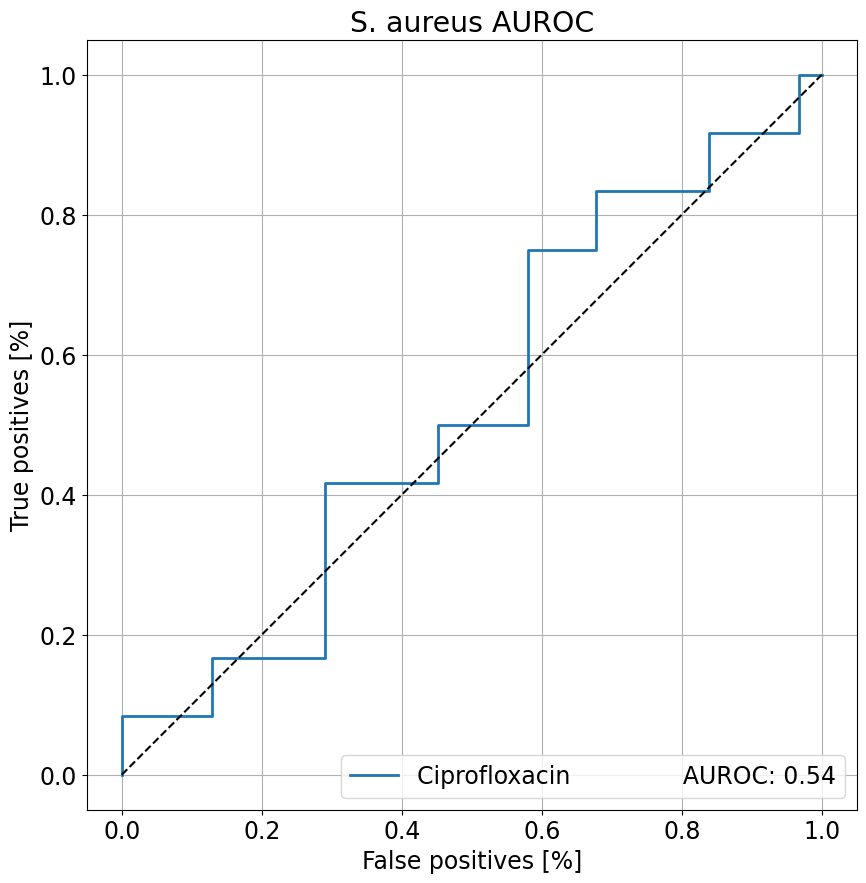

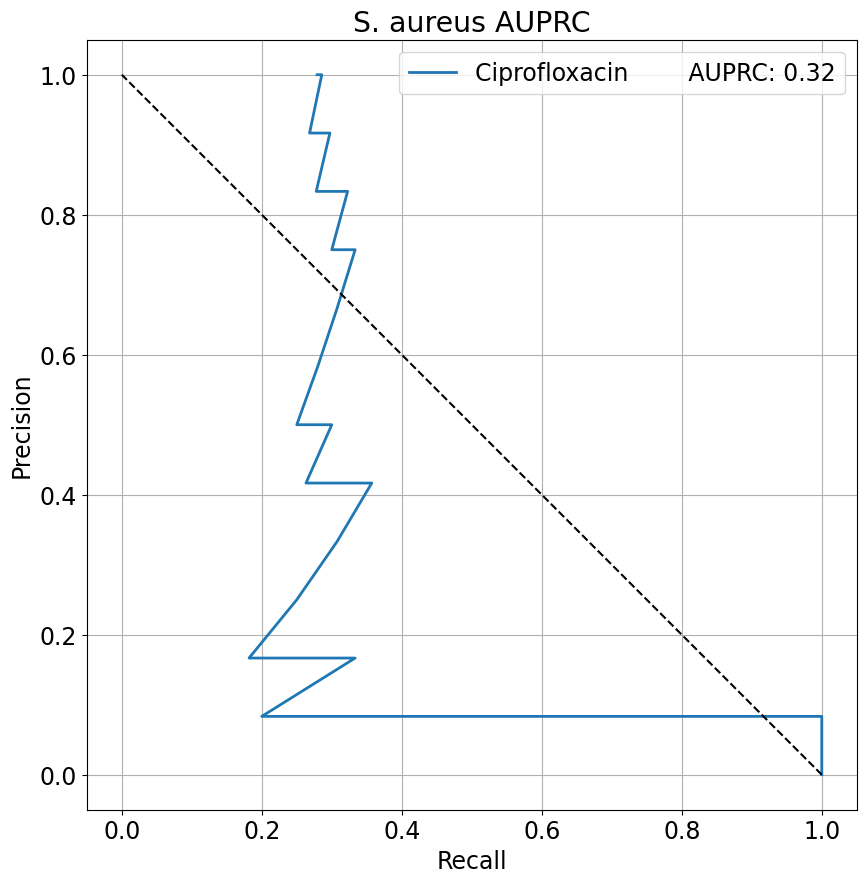

In [47]:
plt.rcParams['figure.figsize'] = (12, 10)
plt.rcParams.update({'font.size': 17})
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

def plot_roc(name, labels, predictions, **kwargs):
  fp, tp, _ = sklearn.metrics.roc_curve(labels, predictions)

  plt.plot(fp, tp, label=name, linewidth=2, **kwargs)
  plt.plot([0, 1], [0, 1], 'k--')
  plt.title('E. coli CNN')
  plt.xlabel('False positives [%]')
  plt.ylabel('True positives [%]')
  plt.title('S. aureus AUROC')

  plt.grid(True)
  ax = plt.gca()
  ax.set_aspect('equal')
plot_roc("Ciprofloxacin               AUROC: %0.2f" % baseline_results[8], y_test, test_predictions_baseline, color=colors[0])

plt.legend(loc='lower right')
plt.savefig('s_aureus_auroc.png', bbox_inches='tight')
plt.show()

def plot_prc(name, labels, predictions, **kwargs):
    precision, recall, _ = sklearn.metrics.precision_recall_curve(labels, predictions)

    plt.plot(precision, recall, label=name, linewidth=2, **kwargs)
    plt.title('S. aureus AUPRC')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.plot([1, 0], [0, 1], 'k--')
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')

plot_prc("Ciprofloxacin        AUPRC: %0.2f" % baseline_results[9], y_test, test_predictions_baseline, color=colors[0])

plt.legend(loc='upper right')
plt.savefig('s_aureus_auprc.png', bbox_inches='tight')
plt.show()